In [1]:
#########################################################################
# LIBRERIAS NECESARIAS
#########################################################################
import gymnasium as gym
import numpy as np
import sinergym
from sinergym.utils.wrappers import LoggerWrapper
import torch

import tensorflow as tf
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
from sklearn.model_selection import train_test_split
import csv

import os
from stable_baselines3.common.vec_env import DummyVecEnv


2023-07-10 15:53:51.572872: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 15:53:51.750307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:53:52.561588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
############################################################################
# Variables globales
###########################################################################
BATCH_SIZE = 28032
EPOCHS =30
EPISODES = 1


In [ ]:
# Definimos el entorno
env = gym.make('Eplus-warehouse-hot-discrete-v1')
env = LoggerWrapper(env)

# Obtenemos el espacio de observaciones y de acciones del entorno
ob_space = env.observation_space
ac_space = env.action_space


[2023-07-08 14:55:49,889] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 14:55:49,889] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 14:55:49,890] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-07-08 14:55:49,890] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-07-08 14:55:49,892] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating building model OutPut:Variable and variables XML tree model for BVCTB connection.
[2023-07-08 14:55:49,892] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating building model OutPut:Variable and variables XML tree model for BV

In [ ]:
# Mostramos el número de observaciones y de acciones del entorno Warehouse
print('\n Nº de observaciones: ', ob_space.shape[0])
print('\n Nº de acciones: ', ac_space.n)



 Nº de observaciones:  23

 Nº de acciones:  10


# Discriminador

## Red neuronal del Discriminador

In [ ]:
# Red neuronal del Discriminador
# Input: listas de longitud ob_space.shape[0] + ac_space.n, [s,a]
# Output: probabilidad de real o falso [0,1]
discriminator_net = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=20, activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=20, activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=20, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()


Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          680       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 20)          420       
                                                                 
 prob (Dense)                (None, None, 1)           21        
                                                                 
Total params: 1541 (6.02 KB)
Trainable params: 1541 (6.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Discriminador

In [ ]:
# Función de pérdida del Discriminador
# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada [s,a] de la base de datos, REAL
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada [s,a] FALSO
def loss_fn_D(prob1, prob2):
    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))
    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))
    
    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)
    
    loss = loss_expert + loss_agent
    
    loss = -loss

    return loss


## Clase del Discriminador

In [ ]:
class Discriminator:
    def __init__(self,env,discriminator_net,expert_s,expert_a,agent_s,agent_a):

        # -Red neuronal del Discriminador
        self.discriminator_net = discriminator_net

        # -Experto: [s,a]
        self.expert_s = expert_s
        self.expert_a = expert_a
        expert_a_one_hot = tf.one_hot(self.expert_a, depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot += tf.random.normal(tf.shape(expert_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        self.expert_s_a = tf.concat([self.expert_s, expert_a_one_hot], axis=1)

        # -Agente:  [s,a]
        self.agent_s = agent_s
        self.agent_a = agent_a
        agent_a_one_hot = tf.one_hot(self.agent_a, depth=env.action_space.n)
        agent_a_one_hot += tf.random.normal(tf.shape(agent_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        self.agent_s_a = tf.concat([self.agent_s, agent_a_one_hot], axis=1)

        # Calculamos la salida de la red para [s,a] del experto y del agente ya
        # que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert = self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent = self.discriminator_net(self.agent_s_a)

        # -Recompensa obtenida cuando el Agente realiza [s,a] falsas
        # log(P(expert|s,a)) cuando mas grande es mejor el agente
        self.rewards = tf.math.log(tf.clip_by_value(self.prob_agent, 1e-10, 1))

    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [ ]:
# Red neuronal del Generador donde se producen acciones
# Input: estados, listas de tamaño 20, s=[s1,s2,s3,....,s17]
# Output: acciones, listas de tamaño 10, a=[a1,a2,....,a10]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=20, activation=tf.tanh, name='layer1'),
        layers.Dense(units=20, activation=tf.tanh, name='layer2'),
        layers.Dense(units=15, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()


Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          480       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 15)          315       
                                                                 
 layer4 (Dense)              (None, None, 10)          160       
                                                                 
Total params: 1375 (5.37 KB)
Trainable params: 1375 (5.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Red neuronal del Generador donde se producen v_pred
# Input: estados, listas de tamaño 20, s=[s1,s2,s3,....,s17]
# Output: v_pred, listas de tamaño 1, v_pred(s)

generator_net_v_preds = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=20, activation=tf.tanh, name='layer1'),
        layers.Dense(units=20, activation=tf.tanh, name='layer2'),
        layers.Dense(units=1, activation=None, name='layer3'),
    ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()


Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          480       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 1)           21        
                                                                 
Total params: 921 (3.60 KB)
Trainable params: 921 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [ ]:
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated" 
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)
    
    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss


## Clase del Generador

In [ ]:
# Clase del GENERADOR: política con su optimizador PPO
# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase
# Policy_net en lugar de generator

class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env = env
        env.reset()

        # -Modelo: El algoritmo de Optimización de Política Proximal, PPO, combina ideas del algoritmo A2C
        # (que utiliza múltiples trabajadores) y del algoritmo TRPO (que utiliza una región de confianza para
        # mejorar el actor).
        self.model = PPO(policy="MlpPolicy", env=env, verbose=0)

        self.model.learn(total_timesteps=25)  # 25000)

        # -Observación inicial a partir de la cual se crean las acciones iniciales
        # haciendo uso de las redes neuronales del generador
        self.obs = np.reshape(np.array(obs), (1, ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs = generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(
            tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)

    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística

    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a] falsos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0

        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            run_policy_steps = 0

            truncated = False
            terminated = False

            # La primera acción de cada episodio se crea con la red neuronal

            obs,_ = env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=[obs])

            act, _ = Old_Policy.act(stochastic=True)

            # Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado
                # como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act = act.numpy()

            elif isinstance(act, np.ndarray):
                act = act

            action = int(act)

            next_obs, reward, terminated, truncated, _ = env.step(action)

            # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
            observations.append(next_obs)  # S_0

            # tenemos una política entrenada
            Policy = Policy_net('policy', env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un
            # estado terminal o un estado malo
            while terminated != True and truncated != True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por
                # eso su tamaño es (1,n)
                action, _ = Policy.get_model().predict(next_obs)

                action = int(action)

                # --Muevo al Agente al siguiente estado
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # --Actualización de variables
                actions.append(action)  # A_i-1
                rewards.append(reward)  # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated:
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    observations.append(next_obs)  # O_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o
            # superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                if success_num >= 100:
                    break
            else:
                success_num = 0

        observations = np.reshape(observations,newshape=[-1] + list(ob_space.shape))

        actions = np.array(actions).astype(dtype=np.int32)

        return observations, actions, rewards, Old_Policy, Policy


In [ ]:
# Clase PPOTrain
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores
# gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, calculo de gradiente y función de pérdida del PPO para despues usarlo en el generador
# de la GAN
class PPOTrain:

    def __init__(self,Policy,Old_Policy,obs,actions,rewards,gamma=0.95):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs = obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()

        policy_dict_ = self.pi_trainable["policy"]
        old_policy_dict_ = self.old_pi_trainable["policy"]

        self.pi = []
        if "policy" in self.pi_trainable and  "policy" in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print("No se encontró la política con el nombre: policy")

        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos
        # nuevos pi_trainable
        self.actions = actions
        self.rewards = rewards
        self.v_preds = self.Old_Policy.get_v_preds()
        self.v_preds_next = self.Policy.get_v_preds()
        
        #  La estimación de la función ventaja GAES, ver paper PPO
        self.gaes = self.get_gaes(self.rewards,self.v_preds,self.v_preds_next)

        act_probs = self.Policy.get_action_prob()
        act_probs_old = self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss = loss_fn_ppo( self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma *v_next - v for r_t, v_next, v in zip(rewards,v_preds_next,v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) -1)):  # es T-1, donde T es time step con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes


# GAIL

In [ ]:
##########################################################################
# CLASE GAIL
##########################################################################

class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self, d_optimizer, loss_fn_D):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D = loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
    
        len_real = X_test.shape[0]

        # Generamos datos falsos dataset_gen = [s,a]^*
        generate_observations, generate_actions, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        dataset_gen = np.concatenate(
            [generate_observations, generate_a_one_hot], axis=1)


        dataset_gen = dataset_gen.astype('float32')
        dataset_gen[-ac_space.n:] = dataset_gen[-ac_space.n:].astype('int32')
        dataset_gen= tf.convert_to_tensor(dataset_gen)
        
        X_test = X_test.astype('float32')
        X_test[-ac_space.n:] = X_test[-ac_space.n:].astype('int32')

    
        len_fakes = dataset_gen.shape[0]


        # Compilamos el discriminador como CNN
        discriminator_net.compile( optimizer=tf.keras.optimizers.Adam( learning_rate=1e-4), loss=loss_fn_D, metrics=['accuracy'])

        #Evaluamos como CNN
        loss_real, acc_real = discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake =discriminator_net.evaluate(dataset_gen, tf.ones((len_fakes, 1)), batch_size=len_fakes, verbose=1)

        print('>Accuracy real: %.0f%%, fake: %.0f%%' %
            (acc_real * 100, acc_fake * 100))
        print('>Loss real: ')
        
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)

    
    # Evaluación del generador

    def evaluate_G(self, X_test):
        # Definimos el entorno
        env = gym.make('Eplus-warehouse-hot-discrete-v1')
        env = LoggerWrapper(env)

        # Numero de episodios donde vamos a evaluar el generador
        EPISODES_EVALUATE_G = 5

        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen
        # la recompensa

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        rewards = []

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la
        # GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated = False
            terminated = False
            R = 0.0
            reward = 0.0

            # Estado inicial del juego
            obs, _ = env.reset()

            # Interactuamos con el Entorno hasta que lleguemos a un estado
            # final
            while terminated != True and truncated != True:
                action, _ = self.generator.get_model().predict(obs)
                obs, reward, terminated, truncated, _ = env.step(
                    int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el
                # step
                R += reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se
            # trata de maximizar
            print("Episode  {} Total reward: {}".format(episode, R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices, rewards)
        plt.show()

    def train_step(self, X_train):
        # Tener en cuenta que no tenemos la misma cantidad de datos verdaderos y falsos, por eso calculamos len_real y len_fakes
        # No podemos controlar la creación de x secuencias [s,a] ya que generaremos tantas secuencias como se
        # necesiten para finalizar el juego
        

        # Generamos datos falsos
        generate_observations, generate_actions, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
            dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
            generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
            dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

    
        dataset_gen = dataset_gen.astype('float32')
        dataset_gen[-10:] = dataset_gen[-10:].astype(int)

        dataset_gen= tf.convert_to_tensor(dataset_gen)

        X_train = tf.strings.to_number(X_train)
        X_train = tf.cast(X_train, dtype=tf.float32)

        combined_images = tf.concat([X_train, dataset_gen], axis=0)
        
        # Longitud de datos son diferentes en [s,a] y [s,a]^*
        len_fakes = dataset_gen.shape[0]
        len_real = X_train.shape[0] 

        # Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido
        # con tf.random.uniform
        labels = tf.concat([tf.ones((len_real, 1)), tf.zeros((len_fakes, 1))],axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        #############  PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR ###############

        # Entrenamiento del discriminador con las [s,a] del agente y del experto combinadas, esto es,
        # le pasamos un conjunto que tiene tanto imágenes reales como imágenes
        # falsas
        with tf.GradientTape() as tape:
            predictions = np.zeros((len_real + len_fakes, ob_space.shape[0] + ac_space.n))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con
            # las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.getNet().trainable_weights)
        )

        ############# PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA  ###########

        # Se realiza todo en la clase PPOTrain
        ppotrain = PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards,obs=generate_observations[0])

        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()

        g_loss = tf.cast(g_loss, dtype=tf.float32)

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}


# Base de datos

In [ ]:
###################################################################################################################################################################
# CREACIÓN DE ARCHIVOS CSV DE ACTIONS.CSV Y OBSERVATIONS.CSV
#################################################################################################################################################################
"""

expert_observations=[]
expert_actions=[]

# Obtenemos observaciones y acciones expertas:
env = gym.make('Eplus-5Zone-hot-discrete-v1')
env = LoggerWrapper(env)


expert_observations = 'observations_.csv'
expert_actions = 'actions_.csv'
with open(expert_observations, 'w', newline='') as expert_observations_csv:
    # Crear el escritor CSV
    escritor_csv_obs=csv.writer(expert_observations_csv)
    with open(expert_actions, 'w', newline='') as expert_actions_csv:
        escritor_csv_act=csv.writer(expert_actions_csv)
        for i in range(1): # ALMACENAMOS DATOS DE 2 AÑOS
            obs, info = env.reset()
            terminated = False
            while not terminated:
                a =env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(a)
               
                escritor_csv_obs.writerow(obs)
               
                escritor_csv_act.writerow([a])
       
env.close()"""


"\n\nexpert_observations=[]\nexpert_actions=[]\n\n# Obtenemos observaciones y acciones expertas:\nenv = gym.make('Eplus-5Zone-hot-discrete-v1')\nenv = LoggerWrapper(env)\n\n\nexpert_observations = 'observations_.csv'\nexpert_actions = 'actions_.csv'\nwith open(expert_observations, 'w', newline='') as expert_observations_csv:\n    # Crear el escritor CSV\n    escritor_csv_obs=csv.writer(expert_observations_csv)\n    with open(expert_actions, 'w', newline='') as expert_actions_csv:\n        escritor_csv_act=csv.writer(expert_actions_csv)\n        for i in range(1): # ALMACENAMOS DATOS DE 2 AÑOS\n            obs, info = env.reset()\n            terminated = False\n            while not terminated:\n                a =env.action_space.sample()\n                obs, reward, terminated, truncated, info = env.step(a)\n               \n                escritor_csv_obs.writerow(obs)\n               \n                escritor_csv_act.writerow([a])\n       \nenv.close()"

In [ ]:
##########################################################################
# CONSTRUCCIÓN DEL DATASET REAL
##########################################################################
with open('observations_warehouse.csv', 'r') as archivo_csv:
    # Crear el lector CSV
    expert_observations = csv.reader(archivo_csv)
    with open('actions_warehouse.csv', 'r') as archivo_csv:
        expert_actions = csv.reader(archivo_csv)

        # Construimos el dataset [s,a] reales y lo dividimos en training y test
        expert_actions = [int(item[0]) for item in list(expert_actions)][:]
        expert_a_one_hot = np.eye(env.action_space.n)[expert_actions]
        expert_observations = list(expert_observations)
        expert_observations = np.array(expert_observations)
        dataset = np.concatenate([expert_observations, expert_a_one_hot], axis=1)

        print('\n Tamanio del dataset: ', dataset.shape)
        print('\n Primera fila del dataset: ', dataset[0])



 Tamanio del dataset:  (35040, 33)

 Primera fila del dataset:  ['1991.0' '1.0' '1.0' '0.0' '4.4' '65.0' '3.875' '145.0' '0.0' '0.0'
 '21.0' '21.0' '20.979212' '20.603912' '0.0' '21.0' '21.0' '19.810043'
 '23.085245' '24.0' '21.316954' '20.50783' '945.9402' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0']


In [ ]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


# Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 28032
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 7008


# Definición de generador y discriminador 

In [ ]:
obs, info = env.reset(seed=1)

print(obs)
# Generador
generator = Policy_net('policy', env, obs)

# Generamos [s,a]=[observations,actions] falsas y las políticas theta_i=Old_Policy y theta_i+1=Policy
observations, actions, rewards, Old_Policy, Policy = generator.generate_fakes()

# Discriminador
discriminator = Discriminator(env,discriminator_net,expert_observations,expert_actions,observations,actions)


[2023-07-08 14:55:50,367] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:55:50,367] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:55:50,462] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run1
[2023-07-08 14:55:50,462] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run1


/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


[1.9910000e+03 1.0000000e+00 1.0000000e+00 0.0000000e+00 4.0000000e+00
 6.9000000e+01 3.0999999e+00 1.3000000e+02 0.0000000e+00 0.0000000e+00
 2.1000000e+01 2.5000000e+01 2.0362167e+01 2.1405642e+01 0.0000000e+00
 2.1000000e+01 2.5000000e+01 2.0997826e+01 2.1426332e+01 2.1000000e+01
 2.1000208e+01 2.0894255e+01 1.2323416e+03]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-07-08 14:56:01,849] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 14:56:01,849] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 14:56:01,850] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:56:01,850] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:56:01,932] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run2
[2023-07-08 14:56:01,932] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run2
[2023-07-08 14:56:13,233] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyP

# EXPERIMENTACIÓN DE GAIL CON WAREHOUSE

## Definición de GAIL

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator)


## Compilación de GAIL

In [ ]:
tf.config.run_functions_eagerly(True)

# Compilación 
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn_D=loss_fn_D
)


## Entrenamiento de GAIL 

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Entrenamiento GAIL
history = gan.fit(X_train,epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[2023-07-08 14:57:57,652] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 14:57:57,652] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 14:57:57,653] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:57:57,653] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 14:57:57,739] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run10
[2023-07-08 14:57:57,739] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run10
[2023-07-08 14:58:08,978] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Energ

## Evaluación del Discriminador 

In [ ]:
gan.evaluate_D(X_test)

[2023-07-08 15:42:35,071] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:42:35,071] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:42:35,072] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 15:42:35,072] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 15:42:35,160] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run190
[2023-07-08 15:42:35,160] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-warehouse-hot-discrete-v1-res6/Eplus-env-sub_run190
[2023-07-08 15:42:46,840] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Ene

## Evaluación del Generador

[2023-07-08 15:48:00,046] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 15:48:00,046] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 15:48:00,046] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 15:48:00,046] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-07-08 15:48:00,048] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-07-08 15:48:00,048] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-07-08 15:48:00

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -45843.3881491954
[2023-07-08 15:48:33,841] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:48:33,841] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:48:33,841] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:48:33,841] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-07-08 15:48:33,844] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 15:48:33,844] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 15:48:33,844] EPLUS_ENV_warehouse-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-07-08 15:48:33,844] EPLUS_ENV_warehouse-hot-discrete-v1_

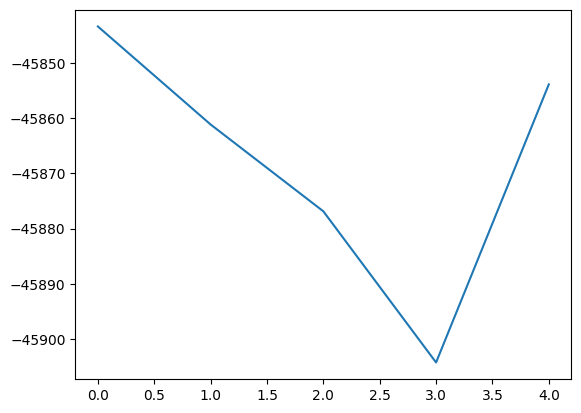

In [ ]:
# Definimos el entorno
env = gym.make('Eplus-warehouse-hot-discrete-v1')
env = LoggerWrapper(env)

# Numero de episodios donde vamos a evaluar el generador
EPISODES_EVALUATE_G = 5

# NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen
# la recompensa

# Lista donde amacenaremos la recompensa acumulada de cada episodio.
rewards = []

# Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
# siguiendo la política que se ha aprendido en el entrenamiento de la
# GAN
for episode in range(EPISODES_EVALUATE_G):
    truncated = False
    terminated = False
    R = 0.0
    reward = 0.0

    # Estado inicial del juego
    obs, _ = env.reset()

    # Interactuamos con el Entorno hasta que lleguemos a un estado
    # final
    while terminated != True and truncated != True:
        action, _ = generator.get_model().predict(obs)
        obs, reward, terminated, truncated, _ = env.step(int(action))

        # Incremento la recompensa del episodio i al haber ejecutado el
        # step
        R += reward

    rewards.append(R)

    # Vemos para el episodio, su recompensa acumulada que es lo que se
    # trata de maximizar
    print("Episode  {} Total reward: {}".format(episode, R))

# Cierro el entorno
env.close()

# Muestro las recompensas obtenidas en cada episodio
indices = range(0, EPISODES_EVALUATE_G)
plt.plot(indices, rewards)
plt.show()